## Info

**Martingale Betting**: Bet the moneyline on a team. If they lose, double the same bet for the same team in their next game.

The purpose of this notebook is first wave of experiments with Martingale betting system.

**Data sources**

* https://www.baseball-reference.com/teams/DET/2021-schedule-scores.shtml
* https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers
* and corresponding websites for other teams/seasons

*note*: the Covers Line is an average comprised of odds from multiple sportsbooks

**terminology**

* team-season: a specific season for a specific team
* refill factor: the number of games you're guaranteed until another refill
* dataset name: a 5 letter string of the 3-letter team abbreviation (on baseball-reference) + last 2 digits of season year

## Import Packages

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from martingale import ds_names, full_run, plot_results, grid_search_by_szn, grid_search_by_team, param_boxplot

## Functions

*moved to martingale.py*

## Analysis

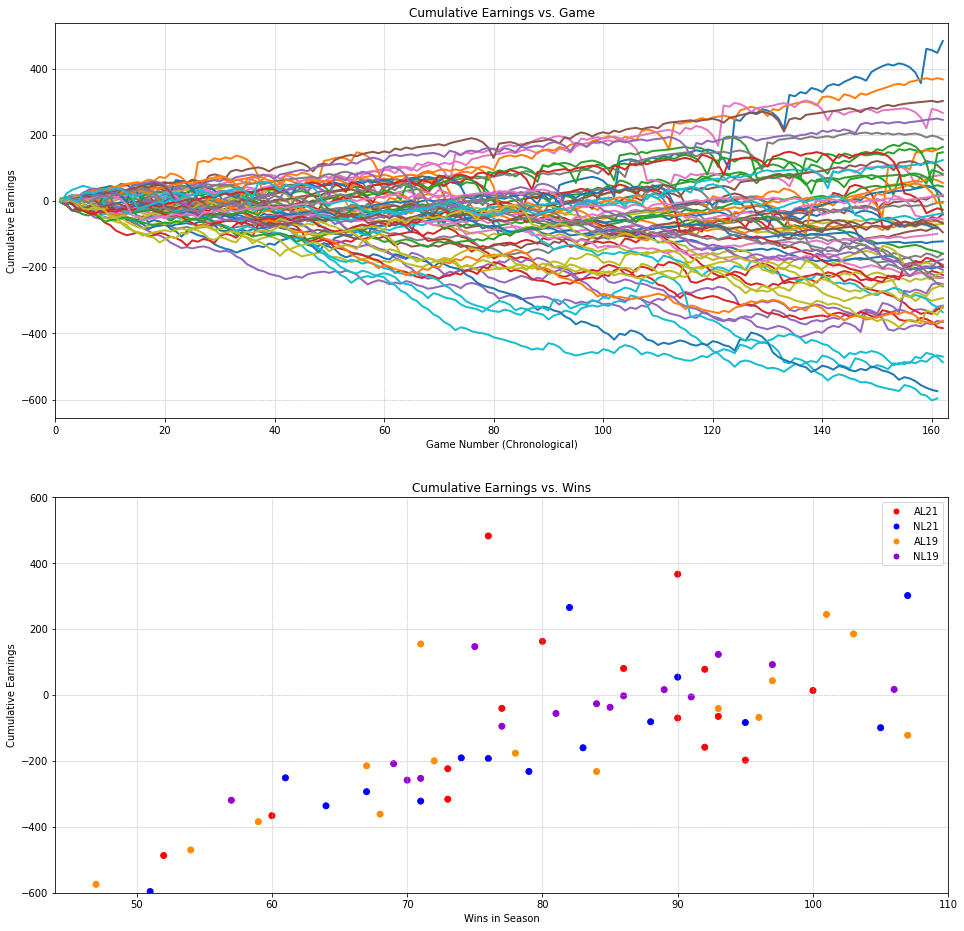

In [2]:
# run once with default parameters: base_bet = 4, start_balance = 50, refill = 2
bet_data, team_data = full_run(ds_names())

# plot results
plot_results(bet_data, team_data)

In [3]:
# grid search by season
params = {'base_bet': [2, 5, 10, 20],
          'start_balance': [25, 50, 100, 200, 1000],
          'refill': [1, 2, 3, 4, 5]
         }
param_gs = grid_search_by_szn(73, params)

grid search complete


In [4]:
# quick analyze results of grid search
param_gs.sort_values(by=['earn_avg', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['pct_pos', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))

,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
95,20.0,1000.0,1.0,222.32,1147.14,57.14,0.19
96,20.0,1000.0,2.0,192.24,1193.71,57.14,0.16
97,20.0,1000.0,3.0,165.26,1223.93,57.14,0.14
98,20.0,1000.0,4.0,150.85,1240.87,57.14,0.12
72,10.0,1000.0,3.0,118.61,762.18,52.38,0.16


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
20,2.0,1000.0,1.0,67.76,276.00,88.1,0.25
22,2.0,1000.0,3.0,67.74,276.07,88.1,0.25
24,2.0,1000.0,5.0,67.31,277.80,88.1,0.24
23,2.0,1000.0,4.0,66.24,282.18,88.1,0.23
21,2.0,1000.0,2.0,66.12,282.68,88.1,0.23


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
20,2.0,1000.0,1.0,67.76,276.00,88.1,0.25
22,2.0,1000.0,3.0,67.74,276.07,88.1,0.25
24,2.0,1000.0,5.0,67.31,277.80,88.1,0.24
23,2.0,1000.0,4.0,66.24,282.18,88.1,0.23
21,2.0,1000.0,2.0,66.12,282.68,88.1,0.23


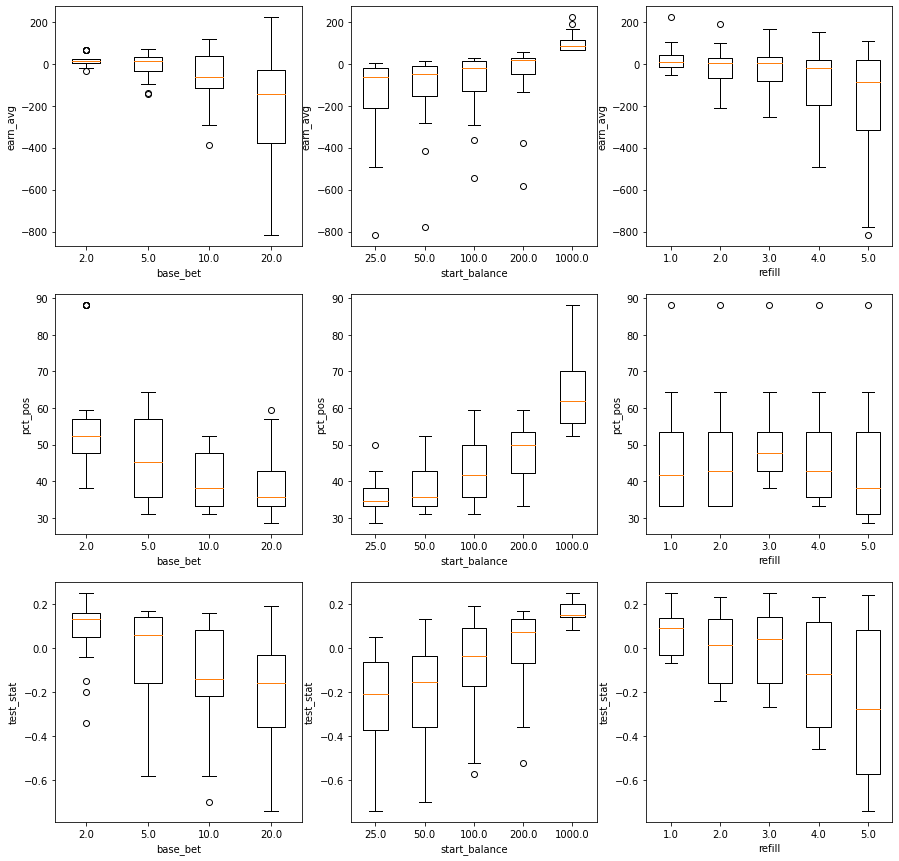

In [9]:
# analyze effect of parameters

mpl.rcParams["figure.figsize"] = [15,15]

plt.subplot(3,3,1)
param_boxplot(param_gs, 'base_bet', 'earn_avg')

plt.subplot(3,3,2)
param_boxplot(param_gs, 'start_balance', 'earn_avg')

plt.subplot(3,3,3)
param_boxplot(param_gs, 'refill', 'earn_avg')

plt.subplot(3,3,4)
param_boxplot(param_gs, 'base_bet', 'pct_pos')

plt.subplot(3,3,5)
param_boxplot(param_gs, 'start_balance', 'pct_pos')

plt.subplot(3,3,6)
param_boxplot(param_gs, 'refill', 'pct_pos')

plt.subplot(3,3,7)
param_boxplot(param_gs, 'base_bet', 'test_stat')

plt.subplot(3,3,8)
param_boxplot(param_gs, 'start_balance', 'test_stat')

plt.subplot(3,3,9)
param_boxplot(param_gs, 'refill', 'test_stat')

In [10]:
# grid search by team

params = {'base_bet': [2, 5, 10, 20],
          'start_balance': [25, 50, 100, 200, 1000],
          'refill': [1, 2, 3, 4, 5]
         }
param_gs = grid_search_by_team(73, params)
param_gs.sort_values(by=['earnings'], inplace=True, ascending=False)
display(param_gs.head(10))

grid search complete


,name,wins,base_bet,start_balance,refill,earnings
4120,det21,76.0,20.0,1000.0,4.0,3341.43
4036,det21,76.0,20.0,1000.0,2.0,3341.43
4162,det21,76.0,20.0,1000.0,5.0,3341.43
4078,det21,76.0,20.0,1000.0,3.0,3341.43
3994,det21,76.0,20.0,1000.0,1.0,3341.43
4123,laa21,77.0,20.0,1000.0,4.0,3134.10
4081,laa21,77.0,20.0,1000.0,3.0,3134.10
4165,laa21,77.0,20.0,1000.0,5.0,3134.10
3997,laa21,77.0,20.0,1000.0,1.0,3134.10
4039,laa21,77.0,20.0,1000.0,2.0,3134.10


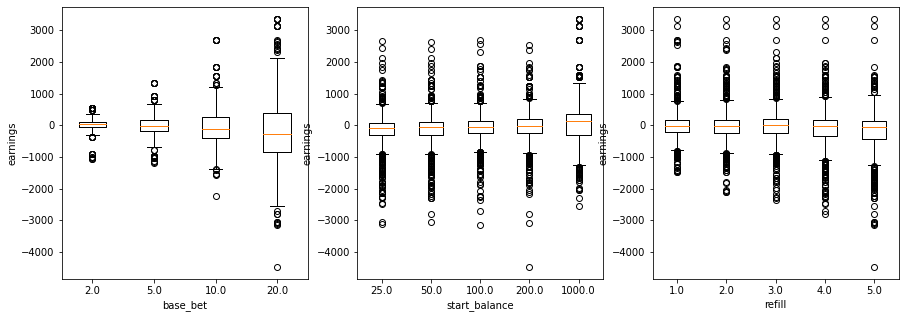

In [11]:
# analyze effect of parameters

mpl.rcParams["figure.figsize"] = [15,5]

plt.subplot(1,3,1)
param_boxplot(param_gs, 'base_bet', 'earnings')

plt.subplot(1,3,2)
param_boxplot(param_gs, 'start_balance', 'earnings')

plt.subplot(1,3,3)
param_boxplot(param_gs, 'refill', 'earnings')

## Discussion

* After the experiments, it has become obvious that the ratio of base_bet / start_balance is a lot more telling than the two when separate. It appears that the lower this ratio is, the better the outcome.
* base_bet: Intuitively, earnings (on average) would increase as base_bet increases, and this was confirmed by the experiments. It seems like having a base bet of 5 would be reasonable when considering risk vs. reward.
* start_balance: This had a greater impact than I thought it would. Earn_avg was positive for every experiment using start_balance = 1000, which couldn't be said about any of the other start balances. I will have to fine tune this number even more to see what the threshold is for positive earn_avg.
* refill: At a refill factor of 5, the earning average and test statistic drop off. I would say that higher refill factor is worse in all cases, but the pct_pos seems to peak at 3. It might be best to only test refill in the range of 1-3 from now on.
* earn_avg, pct_pos, test_stat each provide a unique insight. keep evaluating using all three
* using experiments by team does not tell us much that doing so by season doesn't. use by season from now on
* to be continued in martingale_1.ipynb